In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from VAEModels import VAEModel
from VAEModels import fit_vae

import uproot
import awkward as ak

In [2]:
# Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for CUDA 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

# Use of Variational Autoencoders to Extract the Drell-Yan Angular Coefficients

In this notebook, we use Variational Autoencoders (VAE) to extract the Drell-Yan (DY) angular coefficients from the E906/SeaQuest LH${_2}$/LD${_2}$ targets. The cross-section of the DY angular distribution is given by;

$$
\begin{equation}
\frac{d\sigma}{d\Omega} \propto 1 + \lambda \cos^{2}\theta + \mu\sin2\theta\cos\phi + \frac{\nu}{2} \sin^{2}\theta\cos2\phi
\end{equation}
$$

where $\lambda$, $\mu$ and $\nu$ are DY angular coefficients.

In this example, in the 1st step, we train the VAE using $\phi-\cos\theta$ histograms as inputs with $\lambda = 1.0$, $\mu = 0.0$, and $\nu$ sampled from the uniform distribution $[-0.5, 0.5]$. Then we use the trained VAE to extract the unknown $\nu$ value using the gradient descent algorithm (`Adam`).

In [3]:
# Load binned MC data

vae_tree = uproot.open("BinMCData1D.root:vae_tree")
X_data = vae_tree["bin_count"].array().to_numpy()
theta_data = vae_tree["thetas"].array().to_numpy()[:, 2].reshape(-1, 1)

In [4]:
input_dim = 12* 12
latent_dim = 9
hidden_dim = 30
theta_dim = 1
learining_rate = 0.001
num_epochs = 200
batch_size = 100
early_stopping_patience = 10

In [5]:
model = VAEModel(input_dim, hidden_dim, theta_dim, latent_dim)

In [6]:
# Model summary
print("using device : {}".format(device))
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print('total trainable params: {}'.format(total_trainable_params))

using device : mps
VAEModel(
  (fc_encoder): Sequential(
    (0): Linear(in_features=144, out_features=30, bias=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc_mu): Linear(in_features=30, out_features=9, bias=True)
  (fc_logvar): Linear(in_features=30, out_features=9, bias=True)
  (fc_decoder): Sequential(
    (0): Linear(in_features=10, out_features=30, bias=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=30, out_features=30, bias=True)
    (4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, t

===> Epoch 0/200 Training loss 76.834, Val. loss 72.786 
===> Epoch 10/200 Training loss 76.628, Val. loss 77.481 
Early stopping at epoch 10


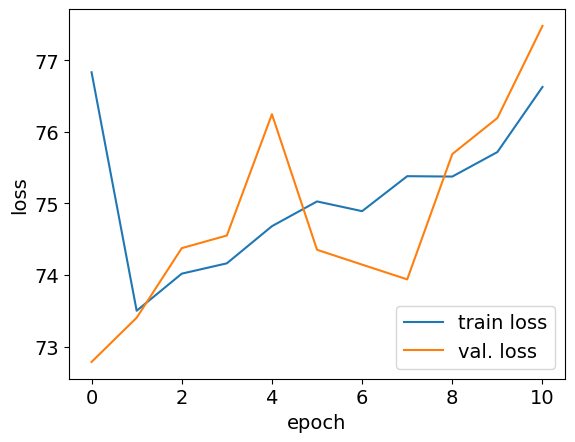

In [7]:
best_model_weights = fit_vae(model, X_data, theta_data, batch_size, learining_rate, num_epochs, early_stopping_patience, device)